In [1]:
import numpy as np
import pandas as pd
import itertools
import glob
import os
import cv2
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
from multiprocessing import Pool
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import random

from lib.io import load_json
from lib.noglobal import noglobal

import seaborn as sns

## Traindata

In [2]:
tl_df = pd.read_csv("/work/data/input/nfl-health-and-safety-helmet-assignment/train_labels.csv");

In [3]:
home_tl_df = tl_df[tl_df["label"].str.contains("H")]
visit_tl_df = tl_df[tl_df["label"].str.contains("V")]

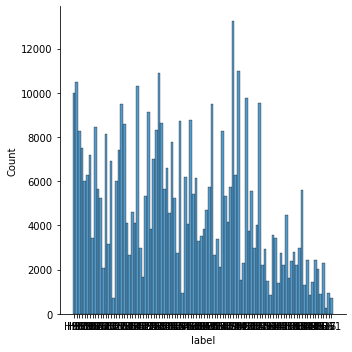

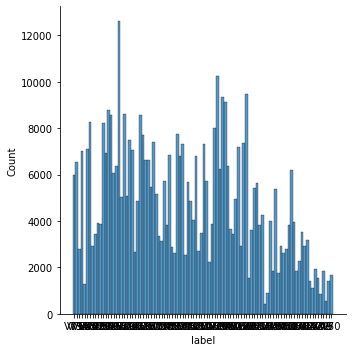

In [4]:
counter = 0;
#fig, axes = get_fig_axes(1,2,(15,10));

sns.displot(home_tl_df["label"])
sns.displot(visit_tl_df["label"])



In [5]:
print(home_tl_df["label"].unique())
print(visit_tl_df["label"].unique())


['H90' 'H97' 'H50' 'H99' 'H30' 'H56' 'H96' 'H36' 'H59' 'H27' 'H22' 'H81'
 'H70' 'H67' 'H51' 'H2' 'H26' 'H65' 'H73' 'H82' 'H85' 'H00' 'H14' 'H25'
 'H71' 'H12' 'H17' 'H29' 'H94' 'H76' 'H53' 'H20' 'H21' 'H23' 'H38' 'H44'
 'H31' 'H52' 'H35' 'H37' 'H74' 'H46' 'H75' 'H10' 'H58' 'H68' 'H69' 'H88'
 'H15' 'H13' 'H42' 'H95' 'H91' 'H39' 'H83' 'H4' 'H77' 'H87' 'H89' 'H54'
 'H98' 'H24' 'H72' 'H1' 'H40' 'H93' 'H28' 'H62' 'H11' 'H57' 'H55' 'H48'
 'H79' 'H34' 'H3' 'H64' 'H84' 'H63' 'H8' 'H19' 'H32' 'H18' 'H6' 'H78'
 'H60' 'H80' 'H33' 'H41' 'H49' 'H47' 'H86' 'H45' 'H92' 'H5' 'H66' 'H16'
 'H7' 'H61']
['V79' 'V72' 'V34' 'V68' 'V5' 'V73' 'V74' 'V86' 'V87' 'V15' 'V13' 'V97'
 'V54' 'V99' 'V59' 'V95' 'V96' 'V55' 'V29' 'V21' 'V26' 'V24' 'V90' 'V28'
 'V35' 'V82' 'V69' 'V25' 'V61' 'V8' 'V71' 'V19' 'V11' 'V14' 'V30' 'V33'
 'V75' 'V89' 'V00' 'V32' 'V57' 'V91' 'V40' 'V93' 'V42' 'V52' 'V23' 'V27'
 'V31' 'V60' 'V12' 'V46' 'V62' 'V77' 'V53' 'V20' 'V94' 'V98' 'V88' 'V70'
 'V10' 'V76' 'V22' 'V18' 'V65' 'V78' 'V3' 'V64'

In [6]:
ss = pd.read_csv("/work/data/input/nfl-health-and-safety-helmet-assignment/sample_submission.csv")
ss["video"] = ss["video_frame"].apply(lambda x:x.split("_")[0])
ss["frame"] = ss["video_frame"].apply(lambda x:x.split("_")[1])


tl_df = pd.read_csv("/work/data/input/nfl-health-and-safety-helmet-assignment/train_labels.csv");
helmets = pd.read_csv("/work/data/input/nfl-health-and-safety-helmet-assignment/train_baseline_helmets.csv")
tracking = pd.read_csv("/work/data/input/nfl-health-and-safety-helmet-assignment/train_player_tracking.csv")


#helmets["video"] = ss["video_frame"].apply(lambda x:x.split("_")[0])
#ss["frame"] = ss["video_frame"].apply(lambda x:x.split("_")[1])


In [7]:
tl_df[tl_df["video_frame"]=="57778_004244_Endzone_1"]

#tl_df[ (tl_df["gameKey"]==57583) & (tl_df["playID"]==82) & (tl_df["frame"] == 1)]
#tl_df[ ]

,video_frame,gameKey,playID,view,video,frame,label,left,width,top,height,impactType,isDefinitiveImpact,isSidelinePlayer
297220,57778_004244_Endzone_1,57778,4244,Endzone,57778_004244_Endzone.mp4,1,H85,305,19,279,18,None,False,False
297221,57778_004244_Endzone_1,57778,4244,Endzone,57778_004244_Endzone.mp4,1,V94,315,19,265,28,None,False,False
297222,57778_004244_Endzone_1,57778,4244,Endzone,57778_004244_Endzone.mp4,1,H74,380,22,265,20,None,False,False
297223,57778_004244_Endzone_1,57778,4244,Endzone,57778_004244_Endzone.mp4,1,V36,401,21,166,27,None,False,False
297224,57778_004244_Endzone_1,57778,4244,Endzone,57778_004244_Endzone.mp4,1,H71,479,18,296,15,None,False,False
297225,57778_004244_Endzone_1,57778,4244,Endzone,57778_004244_Endzone.mp4,1,V98,547,20,269,26,None,False,False
297226,57778_004244_Endzone_1,57778,4244,Endzone,57778_004244_Endzone.mp4,1,H32,553,22,511,22,None,False,False
297227,57778_004244_Endzone_1,57778,4244,Endzone,57778_004244_Endzone.mp4,1,H8,584,20,290,18,None,False,False
297228,57778_004244_Endzone_1,57778,4244,Endzone,57778_004244_Endzone.mp4,1,H63,592,20,279,19,None,False,False
297229,57778_004244_Endzone_1,57778,4244,Endzone,57778_004244_Endzone.mp4,1,V51,629,24,114,31,None,False,False


In [8]:
tracking

,gameKey,playID,player,time,x,y,s,a,dis,o,dir,event
0,57583,82,H97,2018-09-14T00:23:45.500Z,38.89,28.06,0.00,0.00,0.00,261.28,222.79,NaN
1,57583,82,H97,2018-09-14T00:23:45.599Z,38.89,28.06,0.00,0.00,0.00,261.28,221.93,NaN
2,57583,82,H97,2018-09-14T00:23:45.700Z,38.89,28.06,0.00,0.00,0.00,261.28,221.21,NaN
3,57583,82,H97,2018-09-14T00:23:45.799Z,38.88,28.05,0.00,0.00,0.00,261.28,220.07,NaN
4,57583,82,H97,2018-09-14T00:23:45.900Z,38.88,28.05,0.00,0.00,0.00,261.28,220.31,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
333806,58107,4362,V53,2019-12-10T04:33:24.099Z,105.15,36.08,0.38,0.35,0.04,279.23,330.97,NaN
333807,58107,4362,V53,2019-12-10T04:33:24.200Z,105.13,36.09,0.29,0.85,0.03,273.65,300.97,NaN
333808,58107,4362,V53,2019-12-10T04:33:24.299Z,105.11,36.10,0.23,0.91,0.02,268.49,279.58,NaN
333809,58107,4362,V53,2019-12-10T04:33:24.400Z,105.08,36.11,0.21,0.69,0.02,266.05,277.68,NaN


In [9]:
#ss[(ss["video"]=="57906" )& ss["video_frame"].str.contains("Endzone")]["frame"]
display(len(ss["frame"].unique()))
display(len(ss["video"].unique()))

3

3

In [10]:
tl_df

,video_frame,gameKey,playID,view,video,frame,label,left,width,top,height,impactType,isDefinitiveImpact,isSidelinePlayer
0,57583_000082_Endzone_1,57583,82,Endzone,57583_000082_Endzone.mp4,1,H90,245,21,327,29,None,False,False
1,57583_000082_Endzone_1,57583,82,Endzone,57583_000082_Endzone.mp4,1,V79,310,21,345,12,None,False,False
2,57583_000082_Endzone_1,57583,82,Endzone,57583_000082_Endzone.mp4,1,H97,410,21,323,29,None,False,False
3,57583_000082_Endzone_1,57583,82,Endzone,57583_000082_Endzone.mp4,1,V72,443,22,344,16,None,False,False
4,57583_000082_Endzone_1,57583,82,Endzone,57583_000082_Endzone.mp4,1,H50,518,21,212,28,None,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952082,58107_004362_Sideline_99,58107,4362,Sideline,58107_004362_Sideline.mp4,99,V20,637,19,77,21,None,False,False
952083,58107_004362_Sideline_99,58107,4362,Sideline,58107_004362_Sideline.mp4,99,V47,664,22,360,26,None,False,False
952084,58107_004362_Sideline_99,58107,4362,Sideline,58107_004362_Sideline.mp4,99,V24,755,22,416,23,None,False,False
952085,58107_004362_Sideline_99,58107,4362,Sideline,58107_004362_Sideline.mp4,99,V23,822,23,334,24,None,False,False


In [11]:
helmets

,video_frame,left,width,top,height,conf
0,57778_004244_Endzone_1,598,18,278,18,0.080017
1,57778_004244_Endzone_1,856,16,294,22,0.089050
2,57778_004244_Endzone_1,314,21,262,26,0.153076
3,57778_004244_Endzone_1,304,21,280,20,0.821289
4,57778_004244_Endzone_1,585,19,290,19,0.828613
...,...,...,...,...,...,...
1225167,57679_003316_Endzone_336,1002,47,210,48,0.861328
1225168,57679_003316_Endzone_336,898,46,345,54,0.866699
1225169,57679_003316_Endzone_336,1064,50,276,48,0.870117
1225170,57679_003316_Endzone_336,352,48,462,46,0.875000


## Confに関する調査

In [12]:
helmets["video"] = helmets["video_frame"].apply(lambda x: "_".join(x.split("_")[0:-1]))
helmets["video_frame_per_zone"] = helmets["video_frame"].apply(lambda x: x.replace("Endzone_","").replace("Sideline_",""))
helmets["video_per_zone"] = helmets["video_frame"].apply(lambda x: "_".join(x.split("_")[0:-2]))
helmets.loc[helmets["conf"] >= 0.6,"conf_binary"] = 1;
helmets.loc[helmets["conf"] < 0.6,"conf_binary"] = 0;
helmets

,video_frame,left,width,top,height,conf,video,video_frame_per_zone,video_per_zone,conf_binary
0,57778_004244_Endzone_1,598,18,278,18,0.080017,57778_004244_Endzone,57778_004244_1,57778_004244,0.0
1,57778_004244_Endzone_1,856,16,294,22,0.089050,57778_004244_Endzone,57778_004244_1,57778_004244,0.0
2,57778_004244_Endzone_1,314,21,262,26,0.153076,57778_004244_Endzone,57778_004244_1,57778_004244,0.0
3,57778_004244_Endzone_1,304,21,280,20,0.821289,57778_004244_Endzone,57778_004244_1,57778_004244,1.0
4,57778_004244_Endzone_1,585,19,290,19,0.828613,57778_004244_Endzone,57778_004244_1,57778_004244,1.0
...,...,...,...,...,...,...,...,...,...,...
1225167,57679_003316_Endzone_336,1002,47,210,48,0.861328,57679_003316_Endzone,57679_003316_336,57679_003316,1.0
1225168,57679_003316_Endzone_336,898,46,345,54,0.866699,57679_003316_Endzone,57679_003316_336,57679_003316,1.0
1225169,57679_003316_Endzone_336,1064,50,276,48,0.870117,57679_003316_Endzone,57679_003316_336,57679_003316,1.0
1225170,57679_003316_Endzone_336,352,48,462,46,0.875000,57679_003316_Endzone,57679_003316_336,57679_003316,1.0


## conf全体

<AxesSubplot:xlabel='conf', ylabel='Count'>

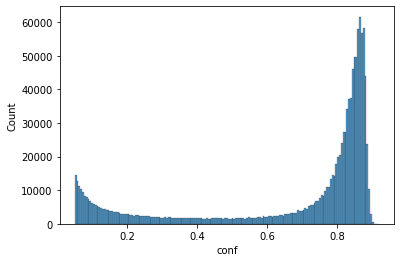

In [13]:
sns.histplot(helmets["conf"])

In [14]:
##

<AxesSubplot:xlabel='conf_binary', ylabel='Count'>

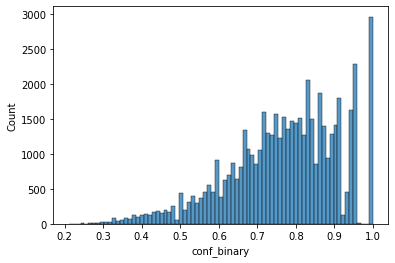

In [15]:
conf_binary_rate_list = [];
key_list = [];

for key,each_df in helmets.groupby("video_frame"):
    
    conf_binary_rate_list.append(each_df["conf_binary"].sum() / each_df.shape[0])
    key_list.append(key);
    
    
    
tmp_df = pd.DataFrame({
    "video":key_list,
    "conf_binary":conf_binary_rate_list        
})

sns.histplot(tmp_df["conf_binary"])

<AxesSubplot:xlabel='conf_binary', ylabel='Count'>

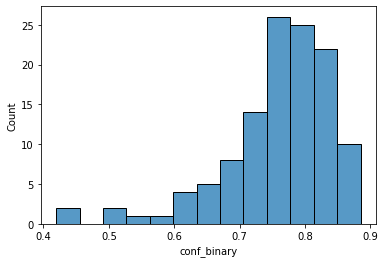

In [16]:
conf_binary_rate_list = [];
key_list = [];

for key,each_df in helmets.groupby("video"):
    
    conf_binary_rate_list.append(each_df["conf_binary"].sum() / each_df.shape[0])
    key_list.append(key);
    
    
    
tmp_df = pd.DataFrame({
    "video":key_list,
    "conf_binary":conf_binary_rate_list        
})

sns.histplot(tmp_df["conf_binary"])

In [17]:
EndZone = helmets[helmets["video_frame"].str.contains("End")]
Sideline = helmets[~helmets["video_frame"].str.contains("End")]

<AxesSubplot:xlabel='conf', ylabel='Count'>

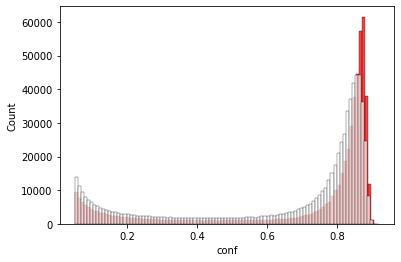

In [18]:
sns.histplot(EndZone["conf"],bins=100,color="red",legend=True)
sns.histplot(Sideline["conf"],bins=100,color="white",legend=True)

In [24]:
helmets[helmets["video_frame"]=="57783_003374_Endzone_1"].sort_values("left")

,video_frame,left,width,top,height,conf,video,video_frame_per_zone,video_per_zone,conf_binary
1175349,57783_003374_Endzone_1,47,25,174,28,0.882812,57783_003374_Endzone,57783_003374_1,57783_003374,1.0
1175336,57783_003374_Endzone_1,216,24,328,17,0.833008,57783_003374_Endzone,57783_003374_1,57783_003374,1.0
1175339,57783_003374_Endzone_1,242,22,281,30,0.856445,57783_003374_Endzone,57783_003374_1,57783_003374,1.0
1175334,57783_003374_Endzone_1,256,20,306,20,0.109375,57783_003374_Endzone,57783_003374_1,57783_003374,0.0
1175343,57783_003374_Endzone_1,311,24,310,18,0.868652,57783_003374_Endzone,57783_003374_1,57783_003374,1.0
1175344,57783_003374_Endzone_1,359,23,130,30,0.869141,57783_003374_Endzone,57783_003374_1,57783_003374,1.0
1175348,57783_003374_Endzone_1,432,26,305,22,0.879395,57783_003374_Endzone,57783_003374_1,57783_003374,1.0
1175337,57783_003374_Endzone_1,493,25,295,33,0.837402,57783_003374_Endzone,57783_003374_1,57783_003374,1.0
1175341,57783_003374_Endzone_1,551,26,306,20,0.863281,57783_003374_Endzone,57783_003374_1,57783_003374,1.0
1175346,57783_003374_Endzone_1,618,24,129,32,0.872559,57783_003374_Endzone,57783_003374_1,57783_003374,1.0
